## Approaches 

    use C3D to extract spatio temporal features from a video

    Average them out to form video signature

    cluster those vectors using kmeans / DBSCAN 

In [1]:
import skvideo.io
from keras.models import Model
%matplotlib inline
# from c3d import C3D
# from sports1M_utils import preprocess_input, decode_predictions


Using TensorFlow backend.


In [2]:
def batch(video_len,batch_size):
    for idx in range(0,video_len,batch_size):
        yield range(idx,min(idx+batch_size,video_len))

In [3]:
from pathlib import Path

In [4]:
def get_file_encoding(path,filename=None,encoding_name='c3d',ext="npy"):
    files = (Path(path) / encoding_name).glob("*."+ext)
    return files

In [5]:
import pandas as  pd
import numpy as np

In [6]:
vid_cat = pd.read_csv('video-category.csv')

In [7]:
from collections import OrderedDict

mapping = OrderedDict(zip(vid_cat.iloc[:,0],vid_cat.iloc[:,1]))

In [8]:
three_d_encode = sorted(get_file_encoding(Path.home() / '.cbvr'))

In [9]:
assert len(three_d_encode) == len(mapping)

In [10]:
all_ = pd.DataFrame()

In [11]:
total_embeds= 0
for val in three_d_encode:
    num = np.load(val)
    vid_id = val.stem.split("_")[0]
    feat_cols = [ 'pixel'+str(i) for i in range(num.shape[1]) ] 
    feat_data = pd.DataFrame(num,columns=feat_cols)
    feat_data['video_id'] = pd.Series(np.tile(int(vid_id),len(num)))
    feat_data['label'] = pd.Series(np.tile(mapping[int(vid_id)],len(num)))
    all_ = all_.append(feat_data,ignore_index=True)
    total_embeds+=len(num)
    

In [12]:
assert len(all_) == total_embeds , "error in reading embeddings"

In [13]:
total_embeds,len(all_)

(19315, 19315)

In [14]:
feat_cols = all_.columns[:4096]

In [15]:
df = all_

In [16]:
rndperm = np.random.permutation(df.shape[0])

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.08674966 0.04609506 0.0276653 ]


/home/deep-vision/.virtualenvs/video-works/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


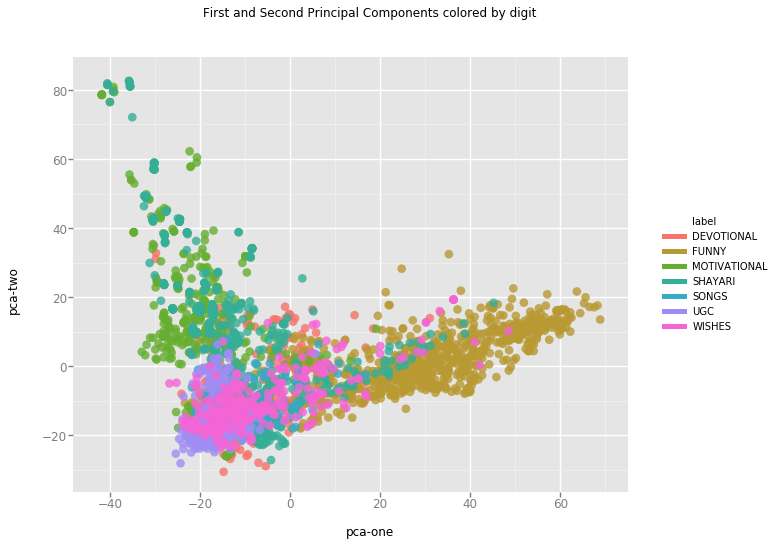

<ggplot: (-9223363295974756064)>

In [18]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two' , z = 'pca-three', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

In [19]:
import time

from sklearn.manifold import TSNE

n_sne = 1000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=700)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.211s...
[t-SNE] Computed neighbors for 1000 samples in 6.886s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 24.842728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.740486
[t-SNE] Error after 700 iterations: 0.790678
t-SNE done! Time elapsed: 23.698602199554443 seconds


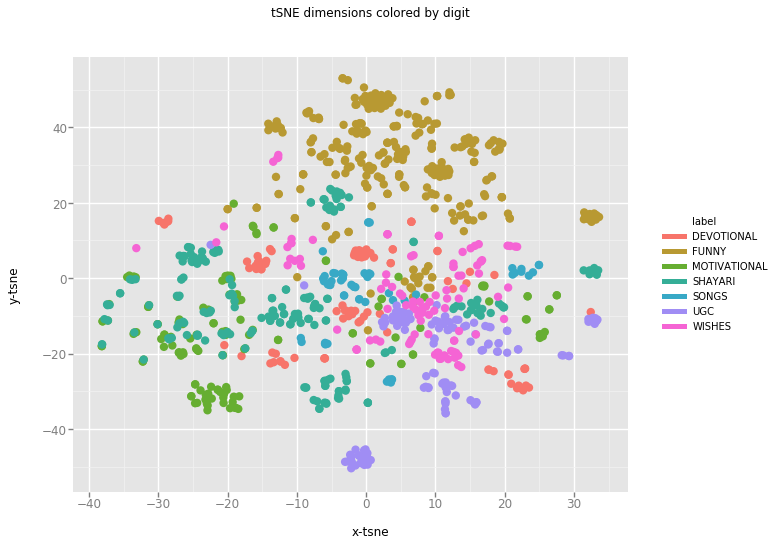

<ggplot: (8740915610295)>

In [20]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [21]:
pca_50 = PCA(0.9)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)

print ('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9001196120746917


In [22]:
pca_result_50.shape

(19315, 591)

In [23]:
X = pca_result_50
# Y = df.labels
ids,labels = df.label.factorize()
len(ids)
Y = ids

In [24]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_img, test_img, train_lbl, test_lbl = train_test_split(
    X, Y, test_size=1/7.0, random_state=0)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_img)

# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

In [26]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver = 'lbfgs')

In [27]:
import time
start = time.time()
logisticRegr.fit(train_img, train_lbl)
end = time.time()
print("time taken is ",(end - start))

time taken is  3.5462026596069336


In [28]:
from sklearn import metrics
# Returns a NumPy Array
# Predict for One Observation (image)
predicted = logisticRegr.predict(test_img)
# generate evaluation metrics
print(metrics.accuracy_score(test_lbl, predicted))


0.9688405797101449


In [29]:
import time

from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(pca_result_50)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19315 samples in 0.769s...
[t-SNE] Computed neighbors for 19315 samples in 297.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19315
[t-SNE] Computed conditional probabilities for sample 2000 / 19315
[t-SNE] Computed conditional probabilities for sample 3000 / 19315
[t-SNE] Computed conditional probabilities for sample 4000 / 19315
[t-SNE] Computed conditional probabilities for sample 5000 / 19315
[t-SNE] Computed conditional probabilities for sample 6000 / 19315
[t-SNE] Computed conditional probabilities for sample 7000 / 19315
[t-SNE] Computed conditional probabilities for sample 8000 / 19315
[t-SNE] Computed conditional probabilities for sample 9000 / 19315
[t-SNE] Computed conditional probabilities for sample 10000 / 19315
[t-SNE] Computed conditional probabilities for sample 11000 / 19315
[t-SNE] Computed conditional probabilities for sample 12000 / 19315
[t-SNE] Computed conditional probabilities for 

In [30]:
# tsne_results

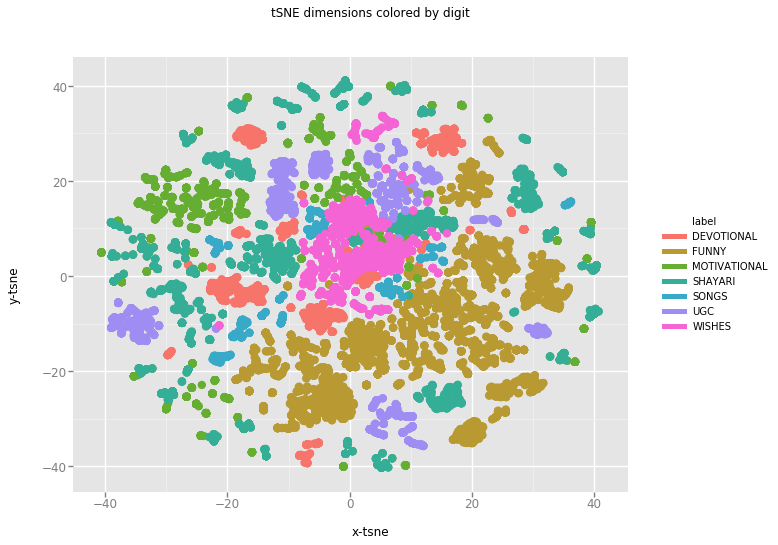

<ggplot: (-9223363295940162879)>

In [31]:
df_tsne = pca_result_50.copy()
feat_cols = [ 'pixel'+str(i) for i in range(df_tsne.shape[1]) ]
df_tsne = pd.DataFrame(df_tsne,columns=feat_cols)
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = df['label']

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [39]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3],
              'gamma': [0.0001,  0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(train_img, train_lbl)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("done in %0.3fs" % (time() - t0))
###############################################################################

Fitting the classifier to the training set
done in 1438.012s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [41]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(test_img)
print("done in %0.3fs" % (time() - t0))

# print(classification_report(test_lbl, y_pred, target_names=target_names))
print(confusion_matrix(test_lbl, y_pred))

###############################################################################

Predicting people's names on the test set
done in 9.406s
0.9702898550724638
[[840   1   0   0   0   0   0]
 [  0 248   0   0   0   1   0]
 [  0   0 333   0  79   0   0]
 [  0   0   0 224   0   0   0]
 [  0   0   1   0 547   0   0]
 [  0   0   0   0   0 325   0]
 [  0   0   0   0   0   0 161]]


In [42]:
print(metrics.accuracy_score(test_lbl, y_pred))

0.9702898550724638


In [44]:
# import numpy
# from sklearn.model_selection import GridSearchCV
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.optimizers import SGD

# # Function to create model, required for KerasClassifier
# def create_model(learn_rate=0.01, momentum=0):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(64, input_dim=8, activation='relu'))
# 	model.add(Dense(, activation='sigmoid'))
# 	# Compile model
# 	optimizer = SGD(lr=learn_rate, momentum=momentum)
# 	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# 	return model


# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)

# # split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]
# # create model
# model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# # define the grid search parameters
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(learn_rate=learn_rate, momentum=momentum)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X, Y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## MLP

In [119]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense , Dropout , BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [51]:

n_classes = len(np.unique(Y))
input_dim = X.shape[1]
n_classes,input_dim

(7, 591)

In [90]:
# encoder = LabelEncoder()
# encoder.fit(train_lbl)
# train_lbl = encoder.transform(Y)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_Y)

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train_lbl = lb.fit_transform(train_lbl)
test_lbl = lb.fit_transform(test_lbl)

In [130]:
# define baseline model
def create_model(init_mode='uniform'):
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=input_dim, kernel_initializer=init_mode,activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(64,activation='relu'))
	model.add(Dropout(0.5))
	model.add(BatchNormalization())
	model.add(Dense(n_classes, activation='softmax'))
	# Compile model
# 	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
	model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
	return model

In [133]:
# model.fit(train_img, train_lbl)
model = create_model()
model.fit(train_img, train_lbl,epochs=30, batch_size=128)

In [135]:
score = model.evaluate(test_img, test_lbl, batch_size=128)

2760/2760 [==============================] - 0s 90us/step


In [136]:
score

[0.058530927017547085, 0.9706521737402763]